# [Bassat et al., 2009](https://pubmed.ncbi.nlm.nih.gov/19936217/) and [Baraka et al., 2014](https://journals.asm.org/doi/10.1128/aac.03647-14)

### **Drug:** AL
### **Genotype:** pfcrt K76 (WT)
### **Number of patients in arm:** 27
### **Number of patients cured:** 25
### **Efficacy:** 0.9259 or 92.59%

### *Loading required libraries*

In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from timeit import default_timer as timer
from matplotlib.ticker import MaxNLocator
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count

# Adjusting only pmax_art with ec50_art set as default
## Simulating 20k patients 
### 50 different values of pmax_art, with min 0.80000 and max 0.99997

In [2]:
# Define the range for pmax_art
min_pmax = 0.99997
max_pmax = 0.80001

# Define pmax_art values
pmax_values = np.linspace(min_pmax, max_pmax, 50)  # 30 values between 0.99997 and 0.8

# Initialize a grid to store the clearance rates
clearance_rates = np.zeros(len(pmax_values))

In [3]:
# Function to run a single simulation for a given pmax_art value
def run_simulation(idx, pmax):
    command_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "20000",
        "--pmax_art", str(pmax)
    ]

    try:
        # Run the command and capture output
        output_pmax_art_adj = subprocess.run(command_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_art_adj = output_pmax_art_adj.stdout.splitlines()
        df_pmax_art_adj = pd.DataFrame([line.split(',') for line in lines_pmax_art_adj], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmax_art_adj = df_pmax_art_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_art_adj[(df_pmax_art_adj['PARASITEDENSITY'] >= 10) & (df_pmax_art_adj['HOUR'] == 671.0)].shape[0]
        total_patients = df_pmax_art_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_art': pmax_values,
    'efficacy': clearance_rates
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_bassat_baraka_pfcrt.k76_pmax_art_adj_50.vals_20k.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_bassat_baraka_pfcrt.k76_pmax_art_adj_50.vals_20k_efficacy.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 50/50 [1:14:57<00:00, 89.96s/it]    


DataFrame saved as pickle and CSV files successfully.


In [4]:
print("The relevant efficacies are: ",(clearance_rates[(clearance_rates >= 92.0) & (clearance_rates <= 93.0)]))

condition = (clearance_rates >= 92.0) & (clearance_rates <= 93.0)
# Get the indices of the values that meet the condition
indices = np.where(condition)[0]
# Retrieve the corresponding pmax_art values using the original indices
corresponding_pmax_values = pmax_values[indices]

print("The corresponding pmax values are: ", corresponding_pmax_values)

The relevant efficacies are:  [92.5   92.005 92.565]
The corresponding pmax values are:  [0.95508102 0.9510002  0.94691939]


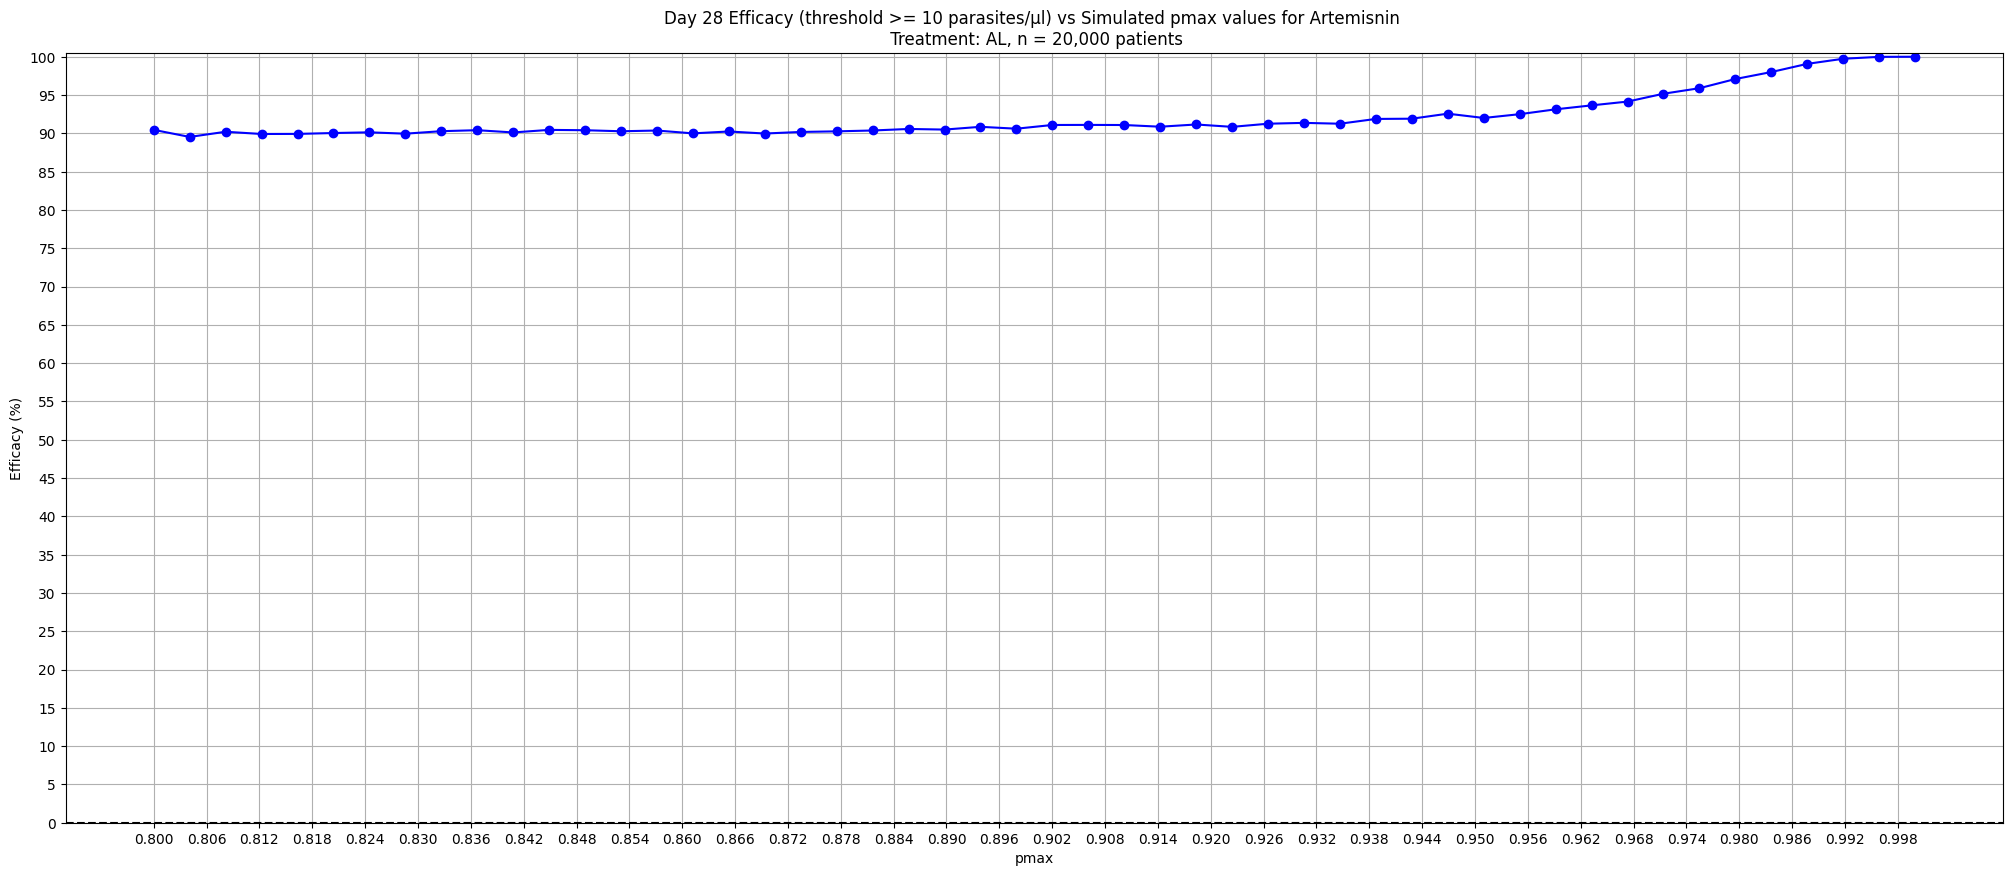

In [5]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel('pmax')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemisnin \n Treatment: AL, n = 20,000 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values), 0.006))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.show()


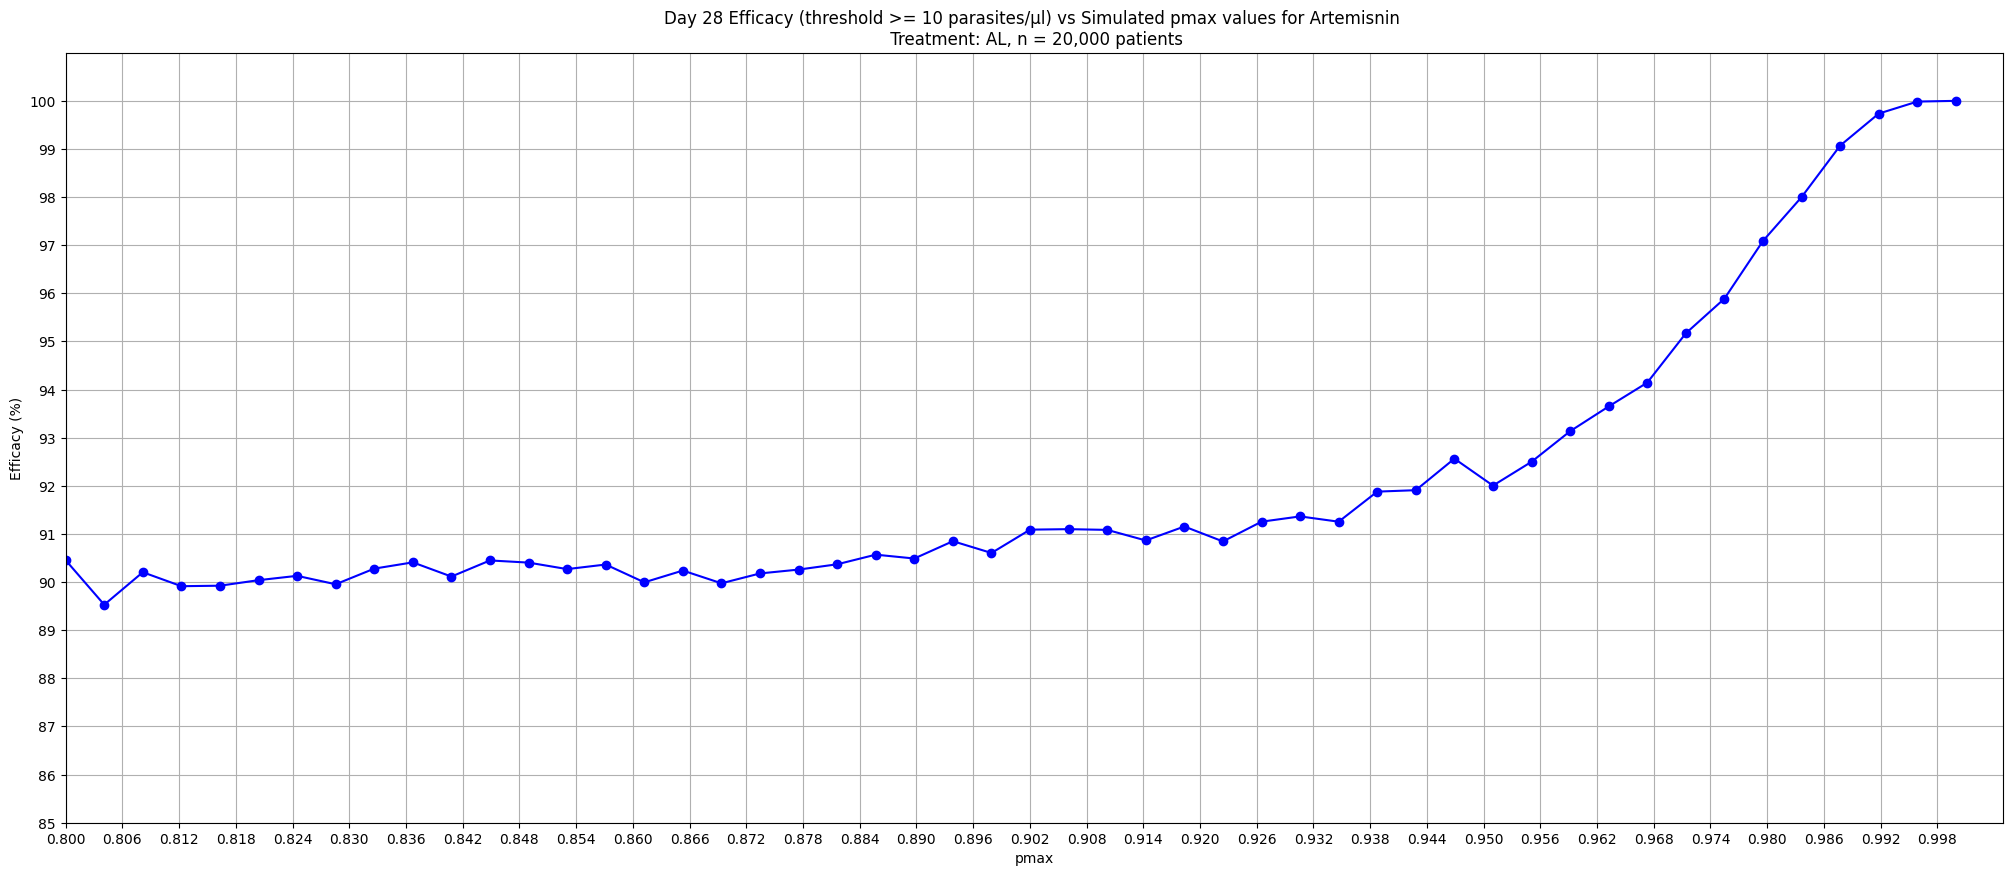

In [6]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel('pmax')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemisnin \n Treatment: AL, n = 20,000 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values), 0.006))  # Adjust tick marks if necessary
plt.xlim(min(pmax_values), max(pmax_values)+0.005)
plt.yticks(np.arange(85, 101, 1))  # Y-axis ticks from 0 to 100%
plt.ylim(85, 101) 
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
# Save the plot as an image
plt.savefig('pkpd_AL_bassat_baraka_pfcrt.K76_20k_efficacy.png', dpi=300, bbox_inches='tight')
plt.show()